# Setting

In [1]:
from pf_utils import DataManager, FinancialRatios, BacktestManager
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'total_return', 'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'

# Data

## Universe: KOSPI200

In [3]:
k200 = DataManager(
    universe = 'kospi200',
    file = 'kospi200_prices_240707lst.csv',
    path = path_data
)
k200.upload()

200 assets from 2000-03-06 to 2024-07-05 uploaded.
df_prices updated


In [4]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

In [5]:
cond = df_k200.notna().sum(axis=1) > 170
df_k200 = df_k200.loc[cond].dropna(axis=1)
df_k200.columns.size

171

## Ratios

In [6]:
WidgetUniverse

In [7]:
file = 'kospi200_ratios.csv'
fr = FinancialRatios(file, path_data)

In [8]:
start = df_k200.index.min()
tickers = df_k200.columns.to_list()[:3]
fr.download(tickers, start) if WidgetUniverse.values(0) else None

In [9]:
fr.upload()

Financial ratios of 3 stocks from 2017-05-31 to 2024-09-30 loaded


In [10]:
fr.calc_rank(metrics='PER', date='start')

PER rank on 2017-05-31


ticker
005380    0.0
000660    0.5
005930    1.0
Name: PER, dtype: float64

In [11]:
tickers = fr.df_ratios.index.get_level_values(0).unique()
df_prc = df_k200[tickers]
df_prc = df_prc.unstack().rename_axis(['ticker','date'])
df_prc

ticker  date      
005930  2017-05-10     45600.0
        2017-05-11     45500.0
        2017-05-12     45820.0
        2017-05-15     46100.0
        2017-05-16     46380.0
                        ...   
005380  2024-07-01    286000.0
        2024-07-02    272500.0
        2024-07-03    276000.0
        2024-07-04    277500.0
        2024-07-05    281000.0
Length: 5283, dtype: float64

In [12]:
fr.interpolate(df_prc)

ticker  date      
005930  2017-05-10    14.720537
        2017-05-11    14.688255
        2017-05-12    14.791557
        2017-05-15    14.881946
        2017-05-16    14.972336
                        ...    
005380  2024-07-01     6.371388
        2024-07-02     6.070641
        2024-07-03     6.148612
        2024-07-04     6.182028
        2024-07-05     6.260000
Length: 5283, dtype: float64

In [11]:
df_adata = fr.calc_historical().unstack(0)
df_adata

PER historical created


ticker,000660,005380,005930
date,,,
2017-05-31,0.5,0.0,1.0
2017-06-30,0.5,0.0,1.0
2017-07-31,1.0,0.0,0.5
2017-08-31,1.0,0.0,0.5
2017-09-30,1.0,0.0,0.5
...,...,...,...
2024-05-31,0.0,0.5,1.0
2024-06-30,0.0,0.5,1.0
2024-07-31,0.0,0.5,1.0


# Backtest

In [14]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

running self.util_check_days_in_year to check days in a year


In [15]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [16]:
bm.buy_n_hold(name='PER', weigh='equally')

Backtesting 2 strategies: KODEX200, PER


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]

Returning stats


,PER,KODEX200
start,2017-05-09,2017-05-09
end,2024-07-05,2024-07-05
total_return,1.276515,0.545298
cagr,0.121814,0.062699
calmar,0.414724,0.164837
max_drawdown,-0.293723,-0.38037
avg_drawdown,-0.027077,-0.04033
avg_drawdown_days,43.472727,78.46875
daily_vol,0.160953,0.18247
daily_sharpe,0.811811,0.432459


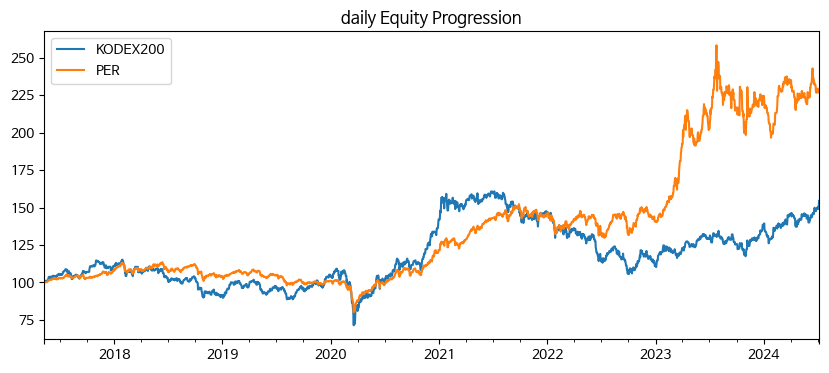

In [17]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

# testing

## testing

In [20]:
from bt.core import Algo, AlgoStack
import pandas as pd
import bt



class SelectMomentum(AlgoStack):
    """
    Sets temp['selected'] based on a simple momentum filter.

    Selects the top n securities based on the total return over
    a given lookback period. This is just a wrapper around an
    AlgoStack with two algos: StatTotalReturn and SelectN.

    Note, that SelectAll() or similar should be called before
    SelectMomentum(), as StatTotalReturn uses values of temp['selected']

    Args:
        * n (int): select first N elements
        * lookback (DateOffset): lookback period for total return
          calculation
        * lag (DateOffset): Lag interval for total return calculation
        * sort_descending (bool): Sort descending (highest return is best)
        * all_or_none (bool): If true, only populates temp['selected'] if we
          have n items. If we have less than n, then temp['selected'] = [].

    Sets:
        * selected

    Requires:
        * selected

    """

    def __init__(
        self,
        n,
        lookback=pd.DateOffset(months=3),
        lag=pd.DateOffset(days=0),
        sort_descending=True,
        all_or_none=False,
    ):
        super(SelectMomentum, self).__init__(
            StatTotalReturn(lookback=lookback, lag=lag),
            SelectN(n=n, sort_descending=sort_descending, all_or_none=all_or_none),
        )


In [ ]:
algos = [
    SelectMomentum(5, 12, 10), 
    bt.algos.RunQuarterly(), 
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
]
strategy = bt.Strategy('test', algos)

bt.Backtest(strategy, df_k200, **kwargs)

In [70]:
import bt
import pandas as pd

data = bt.get('aapl,msft,c,gs,ge', start='2010-01-01')
sma = data.rolling(50).mean()


# first we create the Strategy
s = bt.Strategy('above50sma', [bt.algos.SelectWhere(data > sma),
                               bt.algos.SetStat("test_stat"),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])
s.setup(data, test_stat=data, test_stat2=data)

In [ ]:
# now we create the Backtest
t = bt.Backtest(s, data, 
                additional_data={'test_stat':data, 'test_stat2':data}
               )

# and let's run it!
res = bt.run(t)

#res.plot()

In [67]:
s.get_data('test_stat2')

,aapl,msft,c,gs,ge
Date,,,,,
2010-01-04,6.454504,23.347321,26.157932,133.968124,53.996025
2010-01-05,6.465665,23.354864,27.158092,136.336624,54.275616
2010-01-06,6.362821,23.211536,28.004368,134.881424,53.996025
2010-01-07,6.351057,22.970144,28.081303,137.520905,56.791939
2010-01-08,6.393280,23.128563,27.619696,134.920120,58.015152
...,...,...,...,...,...
2024-10-04,226.800003,416.059998,62.639999,495.160004,187.080002
2024-10-07,221.690002,409.540009,62.599998,494.619995,185.960007
2024-10-08,225.770004,414.709991,63.240002,496.570007,187.470001


In [30]:
df_k200

,005930,000660,005380,207940,000270,068270,105560,005490,055550,028260,...,001680,114090,105630,093370,039130,032350,178920,016380,005250,000670
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-10,45600.0,55600.0,156500.0,177893.0,36100.0,87191.0,53000.0,270000.0,49300.0,124500.0,...,25050.0,22150.0,27350.0,7236.0,85962.0,6977.0,18050.0,48500.0,33500.0,948000.0
2017-05-11,45500.0,56400.0,157500.0,182835.0,36850.0,86106.0,53900.0,270500.0,50800.0,126500.0,...,25400.0,23100.0,27100.0,7412.0,87036.0,7203.0,17800.0,50333.0,33550.0,960000.0
2017-05-12,45820.0,55300.0,155000.0,182835.0,36500.0,86287.0,52900.0,272500.0,50100.0,125500.0,...,25450.0,22800.0,26300.0,7402.0,85766.0,7330.0,17650.0,50167.0,32400.0,962000.0
2017-05-15,46100.0,55600.0,154000.0,184317.0,36800.0,86649.0,54000.0,271000.0,50100.0,125500.0,...,25850.0,22700.0,25900.0,7383.0,86450.0,7321.0,17600.0,49167.0,33200.0,965000.0
2017-05-16,46380.0,55300.0,157500.0,184811.0,36900.0,85745.0,54000.0,273000.0,49900.0,126500.0,...,25800.0,22600.0,24200.0,7529.0,87232.0,7429.0,17200.0,49500.0,32500.0,958000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,81800.0,235500.0,286000.0,759000.0,128600.0,184100.0,79600.0,370500.0,47850.0,140800.0,...,26500.0,12670.0,19700.0,7480.0,58400.0,9880.0,27150.0,6460.0,14130.0,338500.0
2024-07-02,81800.0,232000.0,272500.0,810000.0,123600.0,184500.0,83200.0,365500.0,49500.0,141200.0,...,26100.0,12500.0,19460.0,7210.0,56000.0,9680.0,27600.0,6480.0,14010.0,336000.0
2024-07-03,81800.0,236000.0,276000.0,810000.0,123700.0,181800.0,84400.0,370500.0,51100.0,142300.0,...,25500.0,12260.0,18750.0,7300.0,55800.0,9550.0,27050.0,6410.0,13010.0,332000.0


In [32]:
fr.calc_rank(metrics='PER')

PER rank on 2024-09-30


ticker
005380    0.0
005930    1.0
Name: PER, dtype: float64

In [95]:
#fr.df_ratios['PER'].unstack(0)
df_ratios = fr.df_ratios[['PER','PBR']]
df_ratios

PER   PBR
ticker date                   
005930 2017-05-31  14.43  1.97
       2017-06-30  14.14  1.93
       2017-07-31  14.95  2.04
       2017-08-31  15.38  2.10
       2017-09-30  14.71  2.01
...                  ...   ...
005380 2024-05-31   5.45  0.71
       2024-06-30   5.80  0.75
       2024-07-31   6.26  0.81
       2024-08-31   5.55  0.72
       2024-09-30   5.38  0.70

[267 rows x 2 columns]

In [96]:
df_ratios.groupby('date').rank()

PER  PBR
ticker date                
005930 2017-05-31  3.0  3.0
       2017-06-30  3.0  3.0
       2017-07-31  2.0  3.0
       2017-08-31  2.0  3.0
       2017-09-30  2.0  2.0
...                ...  ...
005380 2024-05-31  2.0  1.0
       2024-06-30  2.0  1.0
       2024-07-31  2.0  1.0
       2024-08-31  2.0  1.0
       2024-09-30  2.0  1.0

[267 rows x 2 columns]

In [77]:
idx = pd.IndexSlice
date = '2017-05-31'
df_ratios.groupby('date').rank().loc[idx[:, date]]

ticker
005930    3.0
000660    2.0
005380    1.0
Name: PER, dtype: float64

In [ ]:
def calc_historical(self, metric='PER', scale='minmax'):
    df_ratios = self.df_ratios
    if df_ratios is None:
        return print('ERROR: load ratios first')

    col_date = self.cols_index['date']
    try:
        ascending = self.ratios[metric]
        return (df_ratios[metric].groupby(level=col_date).rank(ascending=ascending)
                .groupby(level=col_date, group_keys=False).apply(lambda x: _scale(self, x, scale))
               )
    except Exception as e:
        return print(f'ERROR: {e}')

In [126]:
def _calc_historical(self, sr_ratio, ascending, scale, col_date):
    return (sr_ratio.groupby(level=col_date).rank(ascending=ascending)
            .groupby(level=col_date, group_keys=False).apply(lambda x: _scale(self, x, scale))
           )

def calc_historical(self, metrics='PER', scale='minmax'):
    df_ratios = self.df_ratios
    if df_ratios is None:
        return print('ERROR: load ratios first')
    
    if isinstance(metrics, str):
        metrics = [metrics]

    try:
        df_r = df_ratios[metrics]
    except KeyError as e:
        return print(f'ERROR: KeyError {e}')
    
    if len(metrics) > 1:
        if scale not in ['minmax', 'zscore']:
            return print('ERROR: Set scale to sum up multiple ranks')    

    col_date = self.cols_index['date']
    sr_historical = None
    for m in metrics:
        ascending = self.ratios[m]
        sr_h = self._calc_historical(df_r[m], ascending, scale, col_date)
        if sr_historical is None:
            sr_historical = sr_h
        else:
            sr_historical += sr_h
    return sr_historical
    

def _scale(self, sr_rank, scale):
    """
    scale rank
    """
    if scale == 'minmax':
        sr_rank = (sr_rank-sr_rank.min()) / (sr_rank.max()-sr_rank.min())
    elif scale == 'zscore':
        sr_rank  = (sr_rank-sr_rank.mean()) / sr_rank.std()
    else:
        pass
    return sr_rank


self = fr

fr._calc_historical = lambda *x: _calc_historical(fr, *x)


#calc_historical(self).unstack(0).sum(axis=1).mean()
#df_rank = calc_historical(self).unstack(0)
#df_rank

calc_historical(self, ['PER', 'PBR']).unstack(0)

ticker,000660,005380,005930
date,,,
2017-05-31,1.0,0.0,2.0
2017-06-30,1.0,0.0,2.0
2017-07-31,1.5,0.0,1.5
2017-08-31,1.5,0.0,1.5
2017-09-30,2.0,0.0,1.0
...,...,...,...
2024-05-31,1.0,0.5,1.5
2024-06-30,1.0,0.5,1.5
2024-07-31,1.0,0.5,1.5


In [127]:
calc_historical(self, ['PER']).unstack(0)

ticker,000660,005380,005930
date,,,
2017-05-31,0.5,0.0,1.0
2017-06-30,0.5,0.0,1.0
2017-07-31,1.0,0.0,0.5
2017-08-31,1.0,0.0,0.5
2017-09-30,1.0,0.0,0.5
...,...,...,...
2024-05-31,0.0,0.5,1.0
2024-06-30,0.0,0.5,1.0
2024-07-31,0.0,0.5,1.0


In [ ]:
from pf_utils import convert_to_daily

df = df_k200[df_rank.columns]
convert_to_daily

In [119]:
df = df_k200[df_rank.columns]
df_rank2 = pd.DataFrame(None, index=df.index).join(df_rank, how='outer').bfill()
df_rank2 = df_rank2.loc[df.index]
df_rank2

,000660,005380,005930
Date,,,
2017-05-10,0.5,0.0,1.0
2017-05-11,0.5,0.0,1.0
2017-05-12,0.5,0.0,1.0
2017-05-15,0.5,0.0,1.0
2017-05-16,0.5,0.0,1.0
...,...,...,...
2024-07-01,0.0,0.5,1.0
2024-07-02,0.0,0.5,1.0
2024-07-03,0.0,0.5,1.0


In [72]:
s = bt.Strategy("s")

dts = pd.date_range("2010-01-01", periods=3)
data = pd.DataFrame(index=dts, columns=["c1", "c2"], data=100.0)
data.loc[dts[1], "c1"] = 105
data.loc[dts[1], "c2"] = 95

stat = pd.DataFrame(index=dts, columns=["c1", "c2"], data=4.0)
stat.loc[dts[1], "c1"] = 5.0
stat.loc[dts[1], "c2"] = 6.0

algo = bt.algos.SetStat("test_stat")
s.setup(data, test_stat=stat)
s.update(dts[0])
print()
print(s.get_data("test_stat"))
assert algo(s)


             c1   c2
2010-01-01  4.0  4.0
2010-01-02  5.0  6.0
2010-01-03  4.0  4.0


In [73]:
algo(s)

True

In [44]:
data

,c1,c2
2010-01-01,100.0,100.0
2010-01-02,105.0,95.0
2010-01-03,100.0,100.0


In [45]:
stat

,c1,c2
2010-01-01,4.0,4.0
2010-01-02,5.0,6.0
2010-01-03,4.0,4.0


In [ ]:
stat = s.temp["stat"]
assert stat["c1"] == 4.0
assert stat["c2"] == 4.0

s.update(dts[1])
assert algo(s)
stat = s.temp["stat"]
assert stat["c1"] == 5.0
assert stat["c2"] == 6.0


             c1   c2
2010-01-01  4.0  4.0
2010-01-02  5.0  6.0
2010-01-03  4.0  4.0


In [41]:
data

,c1,c2
2010-01-01,100.0,100.0
2010-01-02,105.0,95.0
2010-01-03,100.0,100.0


In [42]:
stat

c1    5.0
c2    6.0
Name: 2010-01-02 00:00:00, dtype: float64

## testing

In [1]:
from pykrx import stock as pyk

In [5]:
%%time

start = '2010-01-01'
end = '2023-12-31'
ticker = "005930"
freq="m"

df = pyk.get_market_fundamental(start, end, ticker, freq=freq)

CPU times: user 117 ms, sys: 7.48 ms, total: 125 ms
Wall time: 21.3 s


/home/lbk/.cache/pypoetry/virtualenvs/pf-APoYtgC9-py3.12/lib/python3.12/site-packages/pykrx/stock/stock_api.py:46: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').apply(how)


In [15]:
df.head()

,BPS,PER,PBR,EPS,DIV,DPS
날짜,,,,,,
2010-01-31,457368,21.47,1.77,37684,0.68,5500
2010-02-28,457368,20.62,1.70,37684,0.71,5500
2010-03-31,457368,20.43,1.68,37684,0.71,5500
2010-04-30,457368,22.42,1.85,37684,0.65,5500
2010-05-31,508420,12.66,1.63,65499,0.97,8000


In [18]:
df.assign(ticker=ticker).set_index('ticker', append=True)

,,BPS,PER,PBR,EPS,DIV,DPS
날짜,ticker,,,,,,
2010-01-31,005930,457368,21.47,1.77,37684,0.68,5500
2010-02-28,005930,457368,20.62,1.70,37684,0.71,5500
2010-03-31,005930,457368,20.43,1.68,37684,0.71,5500
2010-04-30,005930,457368,22.42,1.85,37684,0.65,5500
2010-05-31,005930,508420,12.66,1.63,65499,0.97,8000
...,...,...,...,...,...,...,...
2023-08-31,005930,50817,8.82,1.40,8057,2.03,1444
2023-09-30,005930,50817,8.81,1.40,8057,2.03,1444
2023-10-31,005930,50817,8.38,1.33,8057,2.14,1444


<Axes: xlabel='날짜'>

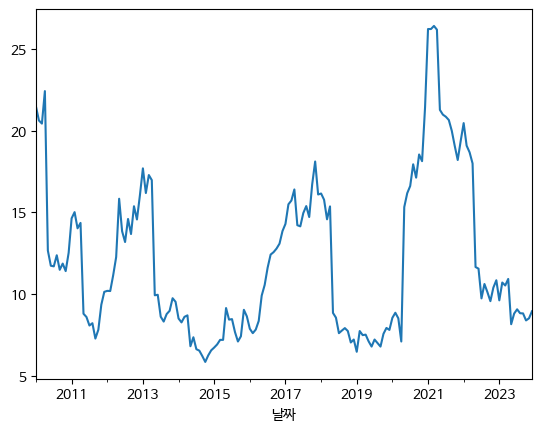

In [7]:
df.PER.plot()

## testing

In [7]:
from pf_utils import DataManager, TimeTracker
from pykrx import stock as pyk

In [2]:
metrics2 = [
    'total_return', 'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

In [3]:
# universe and file
uv_k200 = ['kospi200', 'kospi200_prices.csv']
uv_krx = ['krx', 'krx_prices.csv']
uv_etf  = ['etf', 'etfs_all.csv']
uv_irp  = ['fund', 'funds_irp.csv']
uv_hana = ['fund', 'funds_kebhana.csv']

In [4]:
k200 = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_k200))
)
k200.upload()

201 assets from 2021-01-04 to 2024-10-08 uploaded.
df_prices updated


In [5]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

In [9]:
import pandas as pd
from tqdm import tqdm

date_format = '%Y-%m-%d'
start = df_k200.index.min().strftime(date_format)
end = df_k200.index.max().strftime(date_format)
freq = 'm'

interval = 50
pause_duration = 2
msg = False

tracker = TimeTracker(auto_start=True)
df_ratios = pd.DataFrame()

for ticker in tqdm(df_k200.columns):
    df = pyk.get_market_fundamental(start, end, ticker, freq=freq)
    df = df.assign(ticker=ticker).set_index('ticker', append=True)
    df_ratios = pd.concat([df_ratios, df])
    tracker.pause(interval=interval, pause_duration=pause_duration, msg=msg)
    
    if tracker.pause_count == 2:
        break
tracker.stop()

df_ratios = df_ratios.rename_axis(['date', 'ticker']).swaplevel()

  9%|█████▌                                                        | 18/201 [01:48<18:24,  6.04s/it]


In [22]:
df_ratios.rename_axis(['date', 'ticker']).swaplevel()

BPS    PER   PBR    EPS   DIV   DPS
ticker date                                              
005930 2021-01-31   37528  26.22  2.21   3166  1.71  1416
       2021-02-28   37528  26.22  2.21   3166  1.71  1416
       2021-03-31   37528  26.41  2.23   3166  1.69  1416
       2021-04-30   37528  26.18  2.21   3166  1.71  1416
       2021-05-31   39406  21.27  2.07   3841  3.66  2994
...                   ...    ...   ...    ...   ...   ...
086790 2024-06-30  136601   5.51  0.46  11380  5.42  3400
       2024-07-31  136601   5.29  0.44  11380  5.65  3400
       2024-08-31  136601   5.67  0.47  11380  5.27  3400
       2024-09-30  136601   5.57  0.46  11380  5.36  3400
       2024-10-31  136601   5.23  0.44  11380  5.71  3400

[862 rows x 6 columns]

In [26]:
df_ratios.swaplevel()

BPS    PER   PBR    EPS   DIV   DPS
ticker 날짜                                                
005930 2021-01-31   37528  26.22  2.21   3166  1.71  1416
       2021-02-28   37528  26.22  2.21   3166  1.71  1416
       2021-03-31   37528  26.41  2.23   3166  1.69  1416
       2021-04-30   37528  26.18  2.21   3166  1.71  1416
       2021-05-31   39406  21.27  2.07   3841  3.66  2994
...                   ...    ...   ...    ...   ...   ...
086790 2024-06-30  136601   5.51  0.46  11380  5.42  3400
       2024-07-31  136601   5.29  0.44  11380  5.65  3400
       2024-08-31  136601   5.67  0.47  11380  5.27  3400
       2024-09-30  136601   5.57  0.46  11380  5.36  3400
       2024-10-31  136601   5.23  0.44  11380  5.71  3400

[862 rows x 6 columns]

## class

In [1]:
from pf_utils import DataManager, TimeTracker
from pykrx import stock as pyk

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'total_return', 'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

In [3]:
# universe and file
uv_k200 = ['kospi200', 'kospi200_prices.csv']
uv_krx = ['krx', 'krx_prices.csv']
uv_etf  = ['etf', 'etfs_all.csv']
uv_irp  = ['fund', 'funds_irp.csv']
uv_hana = ['fund', 'funds_kebhana.csv']

In [4]:
k200 = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_k200))
)
k200.upload()

201 assets from 2021-01-04 to 2024-10-08 uploaded.
df_prices updated


In [5]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

In [97]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from pf_utils import get_file_latest, get_filename, save_dataframe


class FinancialRatios():
    def __init__(self, file, path='.', date_format='%Y-%m-%d',
                 cols_index={'date':'date', 'ticker':'ticker'},
                 ratios={'BPS':False, 'PER':True, 'PBR':True, 
                         'EPS':False, 'DIV':False, 'DPS':False}):
        self.file = get_file_latest(file, path) # latest file
        self.path = path
        self.date_format = date_format
        self.ratios = ratios # ratios and its ascending order
        self.cols_index = cols_index
        self.df_ratios = None


    def upload(self):
        """
        load financial ratios from a file
        """
        if self.file is None:
            return print('ERROR: Download first')
        else:
            col_ticker = self.cols_index['ticker']
            f = f'{self.path}/{self.file}'
            df_ratios = pd.read_csv(f, index_col=[0,1], parse_dates=[1], dtype={col_ticker:str})
            self.df_ratios = df_ratios
            return self._print_info(df_ratios, str_sfx='loaded')
        

    def download(self, tickers, start, end=None, freq='m', save=True,
                 # args for TimeTracker.pause
                 interval=50, pause_duration=2, msg=False):
        col_date = self.cols_index['date']
        col_ticker = self.cols_index['ticker']
        if end is None:
            end = datetime.today().strftime(self.date_format)
        
        tracker = TimeTracker(auto_start=True)
        df_ratios = pd.DataFrame()
        
        for ticker in tqdm(tickers):
            df = pyk.get_market_fundamental(start, end, ticker, freq=freq)
            df = df.assign(**{col_ticker:ticker})
            df_ratios = pd.concat([df_ratios, df])
            tracker.pause(interval=interval, pause_duration=pause_duration, msg=msg)
        tracker.stop()
        
        df_ratios = (df_ratios.rename_axis(col_date)
                     .loc[df_ratios.index <= end] # remove fictitious end date of month
                     .set_index(col_ticker, append=True)
                     .swaplevel())
        self._print_info(df_ratios, str_sfx='downloaded')
        self.df_ratios = df_ratios
        if save:
            self.save(self.file, self.path)

    
    def save(self, file=None, path=None, date_format='%y%m%d'):
        """
        date_format: date format for file name
        """
        file = self._check_var(file, self.file)
        path = self._check_var(path, self.path)
        df_ratios = self.df_ratios
        if (file is None) or (df_ratios is None):
            return print('ERROR: check file or df_ratios')

        date = df_ratios.index.get_level_values(1).max().strftime(date_format)
        file = get_filename(file, f'_{date}', r"_\d+(?=\.\w+$)")
        _ = save_dataframe(df_ratios, file, path, msg_succ=f'{file} saved',
                           msg_fail=f'ERROR: failed to save as {file} exists')
        return None


    def get_ratios(self, date=None, metrics=None):
        """
        metrics: list or str
        """
        df_ratios = self.df_ratios
        if df_ratios is None:
            return print('ERROR: load ratios first')
        else:
            date = self._check_date(df_ratios, date)
            if date is None:
                return None

        if metrics is None:
            metrics = df_ratios.columns.to_list()

        col_date = self.cols_index['date']
        df_res = self._get_ratio(df_ratios, date, metrics).droplevel(col_date)

        metrics = '/'.join(metrics) if isinstance(metrics, list) else metrics
        print(f'{metrics} on {date}')
        return df_res
    

    def calc_rank(self, date=None, metrics='PER', topn=10, scale='minmax'):
        """
        calc the rank of financial ratios
        metrics: list or str
        """
        df_ratios = self.df_ratios
        if df_ratios is None:
            return print('ERROR: load ratios first')
        else:
            date = self._check_date(df_ratios, date)
            if date is None:
                return None

        if isinstance(metrics, str):
            metrics = [metrics]

        if len(metrics) > 1:
            if scale not in ['minmax', 'zscore']:
                return print('ERROR: Set scale to sum up multiple ranks')
        
        res_rank = None
        for m in metrics:
            sr_rank = self._calc_rank(df_ratios, date, m, scale)
            if res_rank is None:
                res_rank = sr_rank
            else:
                res_rank += sr_rank 
                
        metrics = '+'.join(metrics)
        print(f'{metrics} rank on {date}')
        col_date = self.cols_index['date']
        return res_rank.droplevel(col_date).sort_values(ascending=True).iloc[:topn]


    def _get_ratio(self, df_ratios, date, metrics):
        """
        get financial ratios on date
        metrics: list or str
        """
        try:
            idx = pd.IndexSlice
            return df_ratios.loc[idx[:,date], metrics]
        except KeyError as e:
            return print(f'ERROR: KeyError {e}')
        

    def _calc_rank(self, df_ratios, date, metric, scale, drop_zero=True):
        """
        calc the rank of a financial ratio
        metric: str
        """
        sr_ratio = self._get_ratio(df_ratios, date, metric)
        if sr_ratio is None:
            return # see _get_ratio for error msg
        
        if drop_zero:
           sr_ratio = sr_ratio.loc[sr_ratio>0]
            
        ascending = self.ratios[metric]
        sr_rank = sr_ratio.rank(ascending=ascending)

        # scale rank
        if scale == 'minmax':
            sr_rank = (sr_rank-sr_rank.min()) / (sr_rank.max()-sr_rank.min())
        elif scale == 'zscore':
            sr_rank  = (sr_rank-sr_rank.mean()) / sr_rank.std()
        else:
            pass
        return sr_rank


    def _check_date(self, df_ratios, date, return_str=True):
        """
        check if date in df_ratios
        """
        dates = df_ratios.index.get_level_values(1).unique()
        if date is not None:
            cond = (dates <= date)
            if cond.sum() == 0:
                return print('ERROR: check date')
            else:
                dates = dates[cond]
        date = dates.max()
        if return_str:
            date = date.strftime(self.date_format)
        return date

    
    def _print_info(self, df, str_pfx='Financial ratios of', str_sfx=''):
        date_format = self.date_format
        dts = df.index.get_level_values(1)
        dt0 = dts.min().strftime(date_format)
        dt1 = dts.max().strftime(date_format)
        n = df.index.get_level_values(0).nunique()
        s1  = str_pfx + " " if str_pfx else ""
        s2  = " " + str_sfx if str_sfx else ""
        return print(f'{s1}{n} stocks from {dt0} to {dt1}{s2}')
        

    def _check_var(self, var_arg, var_self):
        return var_self if var_arg is None else var_arg

    


In [98]:
file = 'test.csv'
path = 'data'
fr = FinancialRatios(file, path)
fr.upload()
fr.df_ratios

Financial ratios of 5 stocks from 2024-01-31 to 2024-09-30 loaded


BPS    PER   PBR    EPS   DIV    DPS
ticker date                                               
068270 2024-01-31   28937  61.72  8.00   3751  0.16    375
       2024-02-29   28937  47.64  6.18   3751  0.21    375
       2024-03-31   28937  46.95  6.09   3751  0.21    375
       2024-04-30   28937  50.15  6.50   3751  0.20    375
       2024-05-31   81950  49.88  2.29   3759  0.27    500
       2024-06-30   81950  47.62  2.18   3759  0.28    500
       2024-07-31   81950  48.98  2.25   3759  0.27    500
       2024-08-31   81950  53.21  2.44   3759  0.25    500
       2024-09-30   81950  52.43  2.41   3759  0.25    500
000270 2024-01-31   98117   7.23  0.99  13495  3.59   3500
       2024-02-29   98117   7.88  1.08  13495  3.29   3500
       2024-03-31   98117   9.31  1.28  13495  2.79   3500
       2024-04-30   98117   8.05  1.11  13495  3.22   3500
       2024-05-31  117495   5.40  1.02  22168  4.68   5600
       2024-06-30  117495   5.44  1.03  22168  4.64   5600
       2024-07-31  117495   5.80  1.09  22168  4.35   5600
       2024-08-31  117495   5.06  0.95  22168  5.00   5600
       2024-09-30  117495   4.79  0.90  22168  5.28   5600
105560 2024-01-31  124124   4.89  0.43  10955  5.50   2950
       2024-02-29  124124   5.60  0.49  10955  4.81   2950
       2024-03-31  124124   6.30  0.56  10955  4.28   2950
       2024-04-30  124124   6.24  0.55  10955  4.31   2950
       2024-05-31  150344   6.24  0.48  11580  4.23   3060
       2024-06-30  150344   6.85  0.53  11580  3.86   3060
       2024-07-31  150344   6.87  0.53  11580  3.84   3060
       2024-08-31  150344   7.63  0.59  11580  3.47   3060
       2024-09-30  150344   7.57  0.58  11580  3.49   3060
005490 2024-01-31  692323  11.77  0.70  41456  2.46  12000
       2024-02-29  692323  10.54  0.63  41456  2.75  12000
       2024-03-31  692323  11.05  0.66  41456  2.62  12000
       2024-04-30  692323  10.08  0.60  41456  2.87  12000
       2024-05-31  714069  17.83  0.56  22382  2.51  10000
       2024-06-30  714069  16.71  0.52  22382  2.67  10000
       2024-07-31  714069  16.55  0.52  22382  2.70  10000
       2024-08-31  714069  16.20  0.51  22382  2.76  10000
       2024-09-30  714069  16.08  0.50  22382  2.78  10000
055550 2024-01-31   92043   4.65  0.43   8454  5.25   2065
       2024-02-29   92043   5.03  0.46   8454  4.86   2065
       2024-03-31   92043   5.23  0.48   8454  4.67   2065
       2024-04-30   92043   5.39  0.49   8454  4.53   2065
       2024-05-31  104769   5.69  0.44   8048  4.59   2100
       2024-06-30  104769   5.84  0.45   8048  4.47   2100
       2024-07-31  104769   5.95  0.46   8048  4.39   2100
       2024-08-31  104769   7.54  0.58   8048  3.46   2100
       2024-09-30  104769   7.00  0.54   8048  3.73   2100

In [99]:
tickers = df_k200.columns.to_list()[5:10]

In [100]:
fr.get_ratios()
#fr.get_ratios(metrics='PER')

BPS/PER/PBR/EPS/DIV/DPS on 2024-09-30


,BPS,PER,PBR,EPS,DIV,DPS
ticker,,,,,,
068270,81950,52.43,2.41,3759,0.25,500
000270,117495,4.79,0.90,22168,5.28,5600
105560,150344,7.57,0.58,11580,3.49,3060
005490,714069,16.08,0.50,22382,2.78,10000
055550,104769,7.00,0.54,8048,3.73,2100


In [101]:
#fr.calc_rank(metrics=['PBR', 'PER', 'EPS'], topn=None)
#fr.calc_rank(metrics='PER', topn=None)
fr.calc_rank(metrics=['PBR', 'PER'], scale=None)

ERROR: Set scale to sum up multiple ranks


In [ ]:
from pf_utils import performance_stats
df = df_k200.loc[df_k200.index >= date, tickers]
performance_stats(df)

https://www.investopedia.com/terms/c/cross_sectional_analysis.asp

In [102]:
file = 'test.csv'
path = 'data'
#tickers = ['086790']
start = '2024-01-01'
fr = FinancialRatios(file, path)

In [ ]:
#fr.download(tickers, start)
#fr.df_ratios

100%|█████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.69s/it]

8.4 secs elapsed, 0.0 secs paused (0.0%)
Financial ratios of 5 stocks from 2024-01-31 to 2024-09-30 downloaded
test_240930.csv saved


In [105]:
fr.upload()
fr.calc_rank(metrics='PER', date='2024-05-01')

Financial ratios of 5 stocks from 2024-01-31 to 2024-09-30 loaded
PER rank on 2024-04-30


ticker
055550    0.00
105560    0.25
000270    0.50
005490    0.75
068270    1.00
Name: PER, dtype: float64

In [106]:
fr.get_ratios(metrics='PER', date='2024-05-01')

PER on 2024-04-30


ticker
068270    50.15
000270     8.05
105560     6.24
005490    10.08
055550     5.39
Name: PER, dtype: float64

## class

In [12]:
df_k200

,005930,000660,005380,207940,000270,068270,105560,005490,055550,028260,...,001680,114090,105630,093370,039130,032350,178920,016380,005250,000670
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-10,45600.0,55600.0,156500.0,177893.0,36100.0,87191.0,53000.0,270000.0,49300.0,124500.0,...,25050.0,22150.0,27350.0,7236.0,85962.0,6977.0,18050.0,48500.0,33500.0,948000.0
2017-05-11,45500.0,56400.0,157500.0,182835.0,36850.0,86106.0,53900.0,270500.0,50800.0,126500.0,...,25400.0,23100.0,27100.0,7412.0,87036.0,7203.0,17800.0,50333.0,33550.0,960000.0
2017-05-12,45820.0,55300.0,155000.0,182835.0,36500.0,86287.0,52900.0,272500.0,50100.0,125500.0,...,25450.0,22800.0,26300.0,7402.0,85766.0,7330.0,17650.0,50167.0,32400.0,962000.0
2017-05-15,46100.0,55600.0,154000.0,184317.0,36800.0,86649.0,54000.0,271000.0,50100.0,125500.0,...,25850.0,22700.0,25900.0,7383.0,86450.0,7321.0,17600.0,49167.0,33200.0,965000.0
2017-05-16,46380.0,55300.0,157500.0,184811.0,36900.0,85745.0,54000.0,273000.0,49900.0,126500.0,...,25800.0,22600.0,24200.0,7529.0,87232.0,7429.0,17200.0,49500.0,32500.0,958000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,81800.0,235500.0,286000.0,759000.0,128600.0,184100.0,79600.0,370500.0,47850.0,140800.0,...,26500.0,12670.0,19700.0,7480.0,58400.0,9880.0,27150.0,6460.0,14130.0,338500.0
2024-07-02,81800.0,232000.0,272500.0,810000.0,123600.0,184500.0,83200.0,365500.0,49500.0,141200.0,...,26100.0,12500.0,19460.0,7210.0,56000.0,9680.0,27600.0,6480.0,14010.0,336000.0
2024-07-03,81800.0,236000.0,276000.0,810000.0,123700.0,181800.0,84400.0,370500.0,51100.0,142300.0,...,25500.0,12260.0,18750.0,7300.0,55800.0,9550.0,27050.0,6410.0,13010.0,332000.0


In [190]:
file = 'kospi200_ratios.csv'
fr = FinancialRatios(file, path_data)
fr.upload()

Financial ratios of 3 stocks from 2017-05-31 to 2024-09-30 loaded


In [114]:
tickers = fr.df_ratios.index.get_level_values(0).unique()
df_prc = df_k200[tickers]
df_prc = df_prc.unstack().rename_axis(['ticker','date'])
df_prc

ticker  date      
005930  2017-05-10     45600.0
        2017-05-11     45500.0
        2017-05-12     45820.0
        2017-05-15     46100.0
        2017-05-16     46380.0
                        ...   
005380  2024-07-01    286000.0
        2024-07-02    272500.0
        2024-07-03    276000.0
        2024-07-04    277500.0
        2024-07-05    281000.0
Length: 5283, dtype: float64

In [128]:
df_ratios = fr.df_ratios.copy()
df_r = df_ratios['PER'].copy()
df_r

ticker  date      
005930  2017-05-31    14.43
        2017-06-30    14.14
        2017-07-31    14.95
        2017-08-31    15.38
        2017-09-30    14.71
                      ...  
005380  2024-05-31     5.45
        2024-06-30     5.80
        2024-07-31     6.26
        2024-08-31     5.55
        2024-09-30     5.38
Name: PER, Length: 267, dtype: float64

In [129]:
import pandas as pd

# get price at the end date of every month
df_p = df_prc.groupby([pd.Grouper(level=0), pd.Grouper(level=1, freq='M')]).last().rename('price')

# update date index as year & date
reset_index = lambda x: x.index.set_levels(x.index.levels[1].to_period('M'), level=1)
df_r.index = reset_index(df_r)
df_p.index = reset_index(df_p)

In [131]:
df = df_r.to_frame().join(df_p).dropna()
df['mpl'] = df.apply(lambda x: x.PER / x.price, axis=1)
df

PER     price       mpl
ticker date                              
005930 2017-05  14.43   44700.0  0.000323
       2017-06  14.14   47540.0  0.000297
       2017-07  14.95   48200.0  0.000310
       2017-08  15.38   46320.0  0.000332
       2017-09  14.71   51280.0  0.000287
...               ...       ...       ...
005380 2024-03   8.96  233000.0  0.000038
       2024-04   7.98  251000.0  0.000032
       2024-05   5.45  253000.0  0.000022
       2024-06   5.80  295000.0  0.000020
       2024-07   6.26  281000.0  0.000022

[261 rows x 3 columns]

In [180]:
(df_prc.rename('price').reset_index(level=1)
       .assign(**{'ym': lambda x: x.date.dt.to_period('M')})
 .join(df.mpl, on=['ticker', 'ym'])
 .set_index('date', append=True)
 .apply(lambda x: x.price * x.mpl, axis=1)
 #.rename('PER')
 .unstack(0)
)

ticker,000660,005380,005930
date,,,
2017-05-10,12.963579,7.469755,14.720537
2017-05-11,13.150105,7.517485,14.688255
2017-05-12,12.893632,7.398160,14.791557
2017-05-15,12.963579,7.350429,14.881946
2017-05-16,12.893632,7.517485,14.972336
...,...,...,...
2024-07-01,0.000000,6.371388,36.053984
2024-07-02,0.000000,6.070641,36.053984
2024-07-03,0.000000,6.148612,36.053984


In [211]:
import pandas as pd


file = 'kospi200_ratios.csv'
fr = FinancialRatios(file, path_data)
fr.upload()


self = fr


def interpolate_bk(self, df_prices, metric='PER', freq='M'):
    df_ratios = self.df_ratios
    if df_ratios is None:
        return print('ERROR')

    col_ticker = self.cols_index['ticker']
    col_date = self.cols_index['date']
    col_price='price'
    col_mpl = 'multiplier'
    col_ym = 'year_month'
    
    # df_ratios[metric] modified forever if not copy
    df_r = df_ratios[metric].copy() 
    
    # get price at the end date of every month
    by = [pd.Grouper(level=0), pd.Grouper(level=1, freq=freq)]
    df_p = df_prices.groupby(by).last().rename(col_price)
    
    # update date index as year & date
    reset_index = lambda x: x.index.set_levels(x.index.levels[1].to_period(freq), level=1)
    df_r.index = reset_index(df_r)
    df_p.index = reset_index(df_p)

    df_r = df_r.to_frame().join(df_p).dropna()
    df_r[col_mpl] = df_r.apply(lambda x: x[metric] / x[col_price], axis=1)

    return (df_prices.rename(col_price).reset_index(level=1)
            .assign(**{col_ym: lambda x: x.date.dt.to_period(freq)})
            .join(df_r[col_mpl], on=[col_ticker, col_ym])
            .set_index(col_date, append=True)
            .apply(lambda x: x[col_price] * x[col_mpl], axis=1)
            .unstack(0))
    
    
def interpolate(self, df_prices, metric='PER', freq='M'):
    df_ratios = self.df_ratios
    if df_ratios is None:
        return print('ERROR')

    col_ticker = self.cols_index['ticker']
    col_date = self.cols_index['date']
    col_price='price'
    col_mpl = 'multiplier'
    col_ym = 'year_month'
    
    # Copy metric column to avoid modifying original
    df_m = df_ratios[metric].copy() 
    
    # Get price at the end date of every month
    by = [pd.Grouper(level=0), pd.Grouper(level=1, freq=freq)]
    df_p = df_prices.groupby(by).last().rename(col_price)
    
    # Update date index to year and month
    reset_index = lambda x: x.index.set_levels(x.index.levels[1].to_period(freq), level=1)
    df_m.index = reset_index(df_m)
    df_p.index = reset_index(df_p)

    # Calculate multiplier from price and metric
    df_m = (df_m.to_frame().join(df_p).dropna()
            .apply(lambda x: x[metric] / x[col_price], axis=1).rename(col_mpl))

    # Return interpolated ratios
    return (df_prices.rename(col_price).reset_index(level=1)
            .assign(**{col_ym: lambda x: x[col_date].dt.to_period(freq)})
            .join(df_m, on=[col_ticker, col_ym])
            .set_index(col_date, append=True)
            .apply(lambda x: x[col_price] * x[col_mpl], axis=1)
            #.unstack(0)
           )


tickers = fr.df_ratios.index.get_level_values(0).unique()
df_prc = df_k200[tickers]
df_prc = df_prc.unstack().rename_axis(['ticker','date'])
df_prc

interpolate(self, df_prc)

Financial ratios of 3 stocks from 2017-05-31 to 2024-09-30 loaded


ticker  date      
005930  2017-05-10    14.720537
        2017-05-11    14.688255
        2017-05-12    14.791557
        2017-05-15    14.881946
        2017-05-16    14.972336
                        ...    
005380  2024-07-01     6.371388
        2024-07-02     6.070641
        2024-07-03     6.148612
        2024-07-04     6.182028
        2024-07-05     6.260000
Length: 5283, dtype: float64

In [212]:
df_prc

ticker  date      
005930  2017-05-10     45600.0
        2017-05-11     45500.0
        2017-05-12     45820.0
        2017-05-15     46100.0
        2017-05-16     46380.0
                        ...   
005380  2024-07-01    286000.0
        2024-07-02    272500.0
        2024-07-03    276000.0
        2024-07-04    277500.0
        2024-07-05    281000.0
Length: 5283, dtype: float64